## New Experimental Approach

#### generating trials  
-> each trial consists of multiple objects, and a final location for the pointing task
 - the trials are configured with the `config` variable
   - there OBJECT_PER_TRIAL objects per trial + another location for the pointing task
   - each trial is configured with;
     - the distance between the objects as determined with a range, specific to trial configuration.what kind of experimental controls?  
     - whether the trial includes crossing the boundary (same setting for all objects within)  
       - we validate that there actually is at least one crossing, if crossing is allowed (specific number configured with MIN_CROSSINGS_IF_ENABLED)
     - border visibility for the trial, specified for the entire trial (not individual movements)
       - this is configured using "countWithBoundary", where there will be that many (N) trials of the same spec with a boundary visible, and (count - N) w/o border visibility
 - we do not keep any distances discrete
   - real world includes noise; for now we are assuming that these variables will be continuous. Therefore,
   - we have a record of all distances *between objects* (movement distance)
       - we had said: "we will want to verify that our distances have consistent means and variances."
           - what does this look like (what report, graph etc. is needed? what is "good"? what is "bad"?)
           - do we want to also do this for pointing ground-truth? (probably!)
 - we validate that the pointing ground-truth is above a threshold (> PTOTASK_GROUND_TRUTH_LOWER_BOUND)
    
#### object display
- participant moves from target to target, revealing the next one each time
 - the object is always visible. if it is on the other side & blocked by boundary, they will know because they won't be able to see it
- objects are the same geometrical shapes of different colors
  - make sure that the colors are color-friendly
      - [] pick a good color scheme
      - [] ask participants about color-blindness
  - vary shape and color from a random pool
    - this increases performance in recall, so that we can actually measure the distance bias
    - [] create a pool of different shapes and colors
    - [] pick randomly for each object
      - [] between participants, look into keeping the seed same
   


#### pointing task / data collection / data analysis
- we want to control for the time and distance elapsed when moving, as well as the time taken for pointing
  - time taken pointing as a potential proxy for confidence?  
 
- we cue the participant for the object to recall
  - pointing task already has the participant inputting data by moving a pseudo-object
    - [] change this to the object that they actually saw 
  - we ask about the objects in a random permutation order
    - we can investigate recency & primacy already, permutation order could enhance or diminish those effects, look into it during analysis.
    
- [] make list of all variables we will be tracking during the analysis
  
  
Data Control: Use 2D np.array for this  
- [] aggregate the histogram over all trials for pair-wise distances
  - let's us see the overall distribution (mean, median, variance, skew - if any) of the distances.
  - compare the distribution of within- and across-boundary cases: side-by-side box plot.
  
- [] generate similar aggregated histogram for ground-truth distances
  - one for all the ground-truths
  - compare the distribution of within- and across-boundary cases: side-by-side box plot.
  - compare the distribution across {1,2,...n}th object within: side-by-side box plot.
      - [] investigate potential interference effect from proximity: (due to our random generation, later points might end up having smaller ground-truth values, and we would like to prevent any potential interference due to this!)

#### implementation
[ ] look into the unity implementation and think about how we can integrate these changes there
    [ ] if possible, start revamping the experiment to follow this approach with some dummy testing trials
   
 - [] think about export format from this scripts - CSV that we read from the Unity

In [2]:
import random
import math
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
OBJECT_PER_TRIAL = 5
MIN_CROSSINGS_IF_ENABLED = 1
PTOTASK_GROUND_TRUTH_LOWER_BOUND = 0.5

WIDTH = 4
LENGTH = 6 # boundary is half-way within length

PLOT_INDIVIDUAL = True
PLOT_ALL = True

In [4]:
# define Point class that will provide some methods of convenience
class Point():
    def __init__(self, x = None, y = None):
        self.x = x
        self.y = y
        
    def __sub__(self, other):
        if not isinstance(other, Point):
            return NotImplementedError()
        else:
            return Point(self.x - other.x, self.y - other.y)
        
    def __add__(self, other):
        if not isinstance(other, Point):
            return NotImplementedError()
        else:
            return Point(self.x + other.x, self.y + other.y)
        
    def __repr__(self):
        return "P(" + str(round(self.x, 2)) + ", " + str(round(self.y, 2)) + ")"
        
    def dist(self, other):
        diff = self - other
        return diff.magnitude()
    
    def magnitude(self):
        return (self.x**2 + self.y**2) ** 0.5
    
    @staticmethod
    def random_circ(dist = 1):
        '''
        generates a random point with the given distance
        defaults to dist = 1 if no distance (on unit circle)
        '''
        theta = random.random() * 360
        x = math.cos(theta) * dist
        y = math.sin(theta) * dist
        
        return Point(x, y)

    @staticmethod
    def random_rect(w = WIDTH, l = LENGTH):
        x = random.random() * w
        y = random.random() * l
        
        return Point(x, y)
        

# test distance and __sub__ functionality (dist uses __sub__)
p1 = Point(0,0)
p2 = Point(3,4)
p1.dist(p2)

5.0

In [5]:
def generate_rand_movement(distance, start = None):
    
    if not start: # no start point given, generate within the rectangle
        start = Point.random_rect()
        
    end = start + Point.random_circ(distance)
    return (start, end)

def pointsOnSameSide(p1, p2):
    mid_y = LENGTH / 2
    
    return (p1.y >= mid_y) == (p2.y >= mid_y)

def distances_between_objects(objs):
    trial_dists = []
    
    for i in range(len(objs)-1):
        trial_dists.append(objs[i].dist(objs[i+1]))
        
    return trial_dists

def validate_movement(start, end, cross, hasBorder):
    buffer = 0.05
    x_lo = buffer * WIDTH
    x_hi = (1 - buffer) * WIDTH
    
    y_lo = buffer * LENGTH
    y_hi = (1 - buffer) * LENGTH
    
    border_lo = (LENGTH / 2) - LENGTH * buffer
    border_hi = (LENGTH / 2) + LENGTH * buffer
    
    isOnSameSide = pointsOnSameSide(start, end)
    
    crossIsCorrect = (isOnSameSide != cross)
    
    bufferFromBoundary = (x_lo < start.x < x_hi) and (x_lo < end.x < x_hi) and (y_lo < start.y < y_hi) and (y_lo < end.y < y_hi)
    bufferFromBorder = not hasBorder or not (border_lo < start.y < border_hi or border_lo < end.y < border_hi)
    
    return crossIsCorrect and bufferFromBoundary and bufferFromBorder

def generate_valid_movement(dist_min, dist_max, cross, hasBorder, start_from = None):
    tries = 0
    max_tries = 10000
    
    while tries < max_tries:
        distance = random.random() * (dist_max - dist_min) + dist_min
        start, end = generate_rand_movement(distance, start_from)
        tries += 1
        
        if validate_movement(start, end, cross, hasBorder):
            return [start, end]
        
    print("valid movement failed after ", tries , " tries")
    return None, None # if no valid movement, return None so that it can be handled


In [6]:
def generate_random_trial(dist_min, dist_max, crossBoundary):

    prev = None
    trial = []
    
    for obj in range(OBJECT_PER_TRIAL-1 + 1): # we add another point at the end for the location from which they'll point to the objects
        # placeholder until we find what specific distance we would like to find
        random_border = random.random() > 0.5
        
        start, end = generate_valid_movement(dist_min, dist_max, crossBoundary, random_border, prev)
        if start is None:
            return None
        if not prev:
            trial.append(start)
            
        trial.append(end)
        prev = end
    return trial

def validate_trial(trial, crossBoundary):
    if not trial: # if we failed, trial will be null
        return False
    # check if number of boundary crossings is more than 0, if there is supposed to be a crossing
    if crossBoundary:
        crossings = 0
        for i in range(len(trial) - 1):
            if not pointsOnSameSide(trial[i], trial[i+1]):
                crossings += 1
            
        if crossings < MIN_CROSSINGS_IF_ENABLED:
            return False
        
    # validate that no ground-truth is less than our lower bound
    pointing_from = trial[-1]
    for t in trial[:-1]:
        if pointing_from.dist(t) < PTOTASK_GROUND_TRUTH_LOWER_BOUND:
            return False
    
    return True

def generate_valid_trial(dist_min, dist_max, crossBoundary):
    tries = 0
    max_tries = 1000
    while tries < max_tries:
        tries += 1
        
        rand_trial = generate_random_trial(dist_min, dist_max, crossBoundary)
        if validate_trial(rand_trial, crossBoundary):
            return rand_trial
    print(f"valid trial failed after {tries} tries")


In [7]:
config = {
    "trials": [
        { # within boundary
            "distanceMin": 0.9,
            "distanceMax": 1.8,
            "crossBoundary": "False",
            "count": 2,
            "countWithBoundary": 1
        },
        { # across boundary
            "distanceMin": 1.5,
            "distanceMax": 4,
            "crossBoundary": "True",
            "count": 2,
            "countWithBoundary": 1
        }
    ]
}

trials = [] # a trial is a set of points, with the last one being where predictions are made from

for cfg_trial in config["trials"]:
    for cfg_trial_i in range(cfg_trial["count"]):
        d_min = cfg_trial["distanceMin"]
        d_max = cfg_trial["distanceMax"]
        c_bounds =  cfg_trial["crossBoundary"] == "True"
        bounds_viz = cfg_trial_i < cfg_trial["countWithBoundary"]
        trials.append({
            "objects": generate_valid_trial(d_min, d_max,c_bounds),
            "boundVis": bounds_viz
        })
trials

valid movement failed after  10000  tries


[{'objects': [P(1.07, 1.26),
   P(1.08, 2.36),
   P(0.87, 1.09),
   P(1.85, 0.51),
   P(0.95, 1.36),
   P(2.24, 1.83)],
  'boundVis': True},
 {'objects': [P(1.78, 3.52),
   P(2.46, 4.43),
   P(2.01, 5.23),
   P(1.54, 3.91),
   P(2.54, 3.89),
   P(0.97, 3.36)],
  'boundVis': False},
 {'objects': [P(2.45, 2.56),
   P(3.43, 4.07),
   P(0.87, 2.37),
   P(2.72, 5.21),
   P(1.58, 1.58),
   P(2.94, 3.74)],
  'boundVis': True},
 {'objects': [P(2.87, 1.4),
   P(2.31, 3.48),
   P(1.86, 1.19),
   P(1.71, 3.5),
   P(2.7, 1.86),
   P(3.33, 5.66)],
  'boundVis': False}]

Mean:1.2296018851506827 Median:1.2385693396855997 Range: 0.2716014761001675 Stdev: 0.09839284857545956


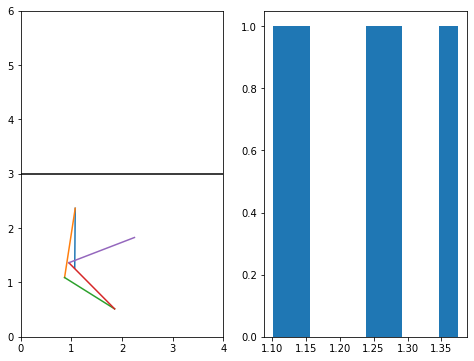

Mean:1.222813723501324 Median:1.135888512891905 Range: 0.7415948680177524 Stdev: 0.27295677683927116


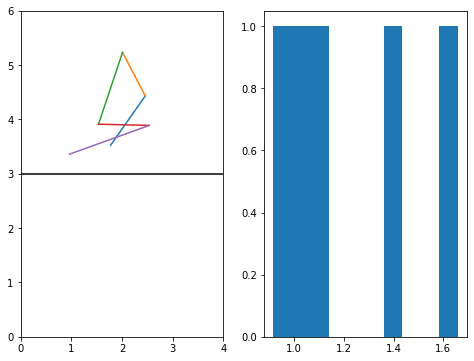

Mean:2.9272267649012798 Median:3.084759511160807 Range: 1.9982923795455683 Stdev: 0.695332888687818


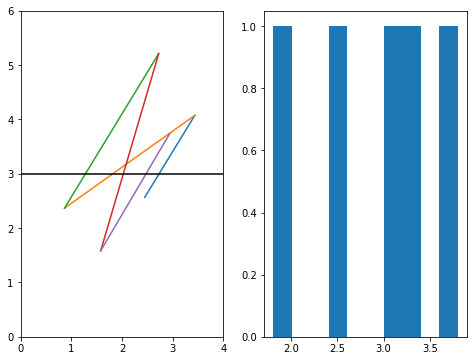

Mean:2.512626213592281 Median:2.3143466874908425 Range: 1.9302349033190656 Stdev: 0.6852643887405194


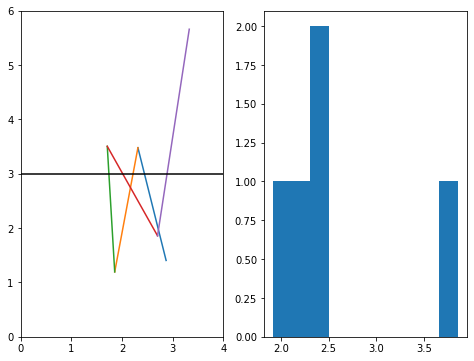

NameError: name 'dist_data' is not defined

In [8]:
def plot_trial(trial):
    objs = trial["objects"]
    fig, axs = plt.subplots(1, 2, figsize=(WIDTH * 2, LENGTH))
    
    prev = objs[0]
    for curr in objs[1:]:
        axs[0].plot([prev.x,curr.x], [prev.y,curr.y])
        prev = curr

    # plot the border in any case
    axs[0].plot([0, WIDTH],[LENGTH/2, LENGTH/2], "k-")
    axs[0].set_xlim(0, WIDTH)
    axs[0].set_ylim(0, LENGTH)
    
    distances = distances_between_objects(objs)
    axs[1].hist(distances)
    
    return distances

trials_dists = []
for trial in trials:
    plot_trial(trial)
    dists = distances_between_objects(trial["objects"])
    trials_dists.append(dists)
    print(f"Mean:{np.mean(dists)} Median:{np.median(dists)} Range: {np.max(dists) - np.min(dists)} Stdev: {np.std(dists)}")
    plt.show()
plt.hist(dist_data.flatten())